# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:** 
 - The white Smartcar stays at the intersection, not moving at all. It idles regardless the light is red or green. We can observe the white Smartcab staying put and many colorful dummy cabs zipping on a grid layout. At any time only one car occupies a road segment between two intersections. The cars waits until the street light, indicated by a red line barring the intersection, turns green. Then the cars can proceed straight, left or right or stay at the intersection.
 - The agent is receiving rewards in the form of negative and positive numbers (points). The rewards don't stay exactly the same for consecutive actions that are apparently the same.
 - When the light is red and the Smartcab is idling, it receives a warying amount of positive reward. We can see this from messages like: <font color=green>Agent properly idled at a red light. (rewarded 1.97) Agent properly idled at a red light. (rewarded 1.27)</font>. When the light is green and the Smartcab is not moving, it is penalized by a varying number of points: <font color="red"> Agent idled at a green light with no oncoming traffic. (rewarded -5.62) Agent idled at a green light with no oncoming traffic. (rewarded -5.20)</font>

It is much easier to see what is going on by reducing the number of dummy cars to 3 in agent.py `env = Environment( num_dummies=3)`

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**
 - agent.py flags:
   - `learning`: If it is set to True the driving agent will use Q-learning. 
   - `epsilon`: - continuous value for exploration factor, default 1. If it's value is 1, the agent will take random actions in each state, ignoring the Q-value table. If it is closer to zero the agent will be less inclined to explore new routes and uses available Q-value to choose the next best action.
   - `alpha` - continuous value for learning rate. If alpha = 1 the agent learns at a maximum rate and does not remember rewards from past actions. If it is set to zero it will not learn at all. The $\hat{Q}$-value will be updated by $ \hat{Q}_{t+1} = \alpha * R(s',a')  + (1 - \alpha) * \max \hat{Q}_{t}$.
 - Environment function `act()` is called when an agent performs an action.
 - `render_text()` outputs the simulation parameters such as reward, violation, etc, when not running in graphical mode, in the terminal. `render()` will draw and update the GUI display with the simulation data.
 - `next_waypoint()` considers East-West direction first.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


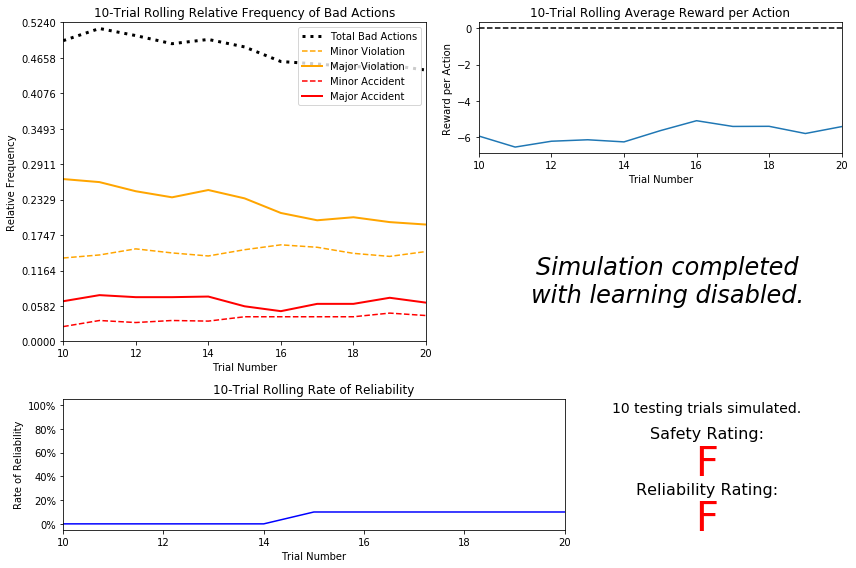

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**
 - The driving agent is making bad decisions about 40% of the time. 2-3% of the time the bad actions result in accidents, minor accidents are about twice as frequent as major accidents.
 - Reliability rate F means that Agent fails to reach the destination on time for at least 60% of trips. This makes sense since it is taking random actions and it has to get there in less than the 5 times the distance steps.
 - The agent is receiving penalty for each step it is taking. The reward (penalty) is consistent for each step, about -4 points.
 - As the number of trials increses the outcome does not seem to be getting any better. It fluctuates but the trend sems to be flat.
 - This Smartcab can not be considered safe. It gets into an accident after making 20 decisions. It is also not reliable, it does not arrive to its destination 80% of the time. 

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**
 - It seems that all of these features may be important in learning safety and efficiency. 
  - `waypoint` seems to be the most important considering efficiency because it following it gives get the agent to the destination most quickly.
  - `inputs` are the most important considering safety. Getting into an accident is really bad so knowing about oncoming traffic is crucial. If the light is red, turning right may be OK if no car is coming from the left going straight or no oncoming traffic is turning left to save time without impacting safety.
  - When considering efficiency, `deadline` may become a factor. The agent may learn that running a red light, when no oncoming traffic is present, may be rewarded. One reason why deadline should not be selected in the state is that its value max value changes randomly for each simulation trial and from step to step. If we had infinitely long time it may be helpful but I will not use it here. Not using it reduces the number of states considerably which help in learning.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**
- This is how we can calcualate state space: count the number of possible values for each input variable the agent gets, multiply them together, and multiply the result with the number of intersections. It is becuase each input variable is independent of the variables.
 - waypoint: 'forward|left|right' => 3
 - inputs: $ 2*4*4*4 = 128$
     - light:    'green|red' => 2
     - oncoming: 'None|forward|left|right' => 4
     - left:     'None|forward|left|right' => 4
     - right:    'None|forward|left|right' => 4
 - [deadline: $5 * \max dist(destination, start) = 5 * (3 + 4) = 35 $)] # not used

 - State space: $ 3 * 128 = 384 $

- Given the number of states, it is feasible for the agent to learn a policy within a reasonable amount of time. If we run the simulation so that that agent visits each state a few times before epsilon falls below the threshold, it can learn to be safe and reliable. We can choose a decay function so that agent goes though each state 10 times: about 3840 states visited. I estimate 10 states per trial which leads to 384 trials about 5 seconds each: learning can complete in about an hour.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

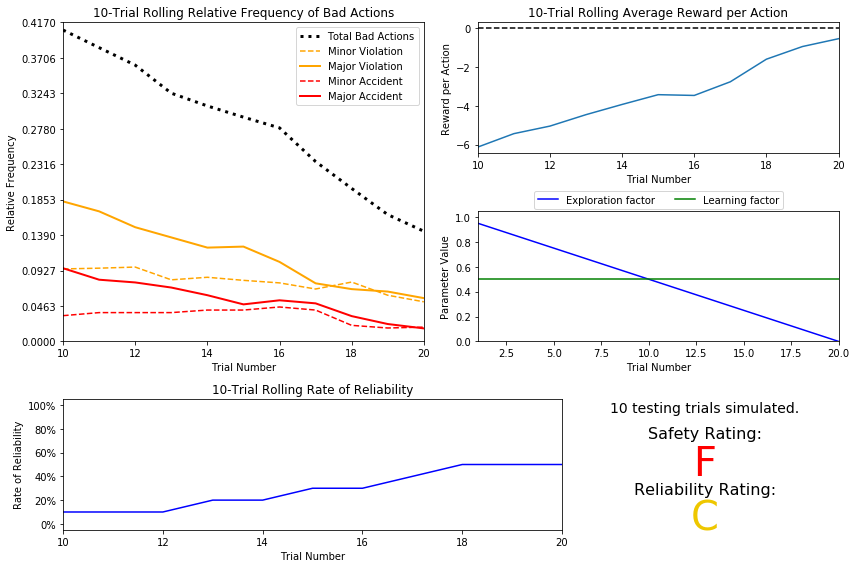

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**
 - The basic driving agent and the Q-learning agent both started out at about 0.4 relative frequency of bad actions. The Q-learning agent improves over time but they both stay below passing grade at least for the training time given. They both eventually have failed the Safety Rating. They both have bad Reliablity rating, although the Q-learing agent does a little better.  
 - The driving agent did 20 trial before testing. That makes sense, since epsilon decays from 1 by 0.05 for each run, and 20 * 0.05 = 1.
 - The decay function is spot on, a straight line from 1 to 0 in 20 steps.
 - The agent is learning no doubt. The number of bad actions decreased over all the types of bad actions, and the rewards increased from -6 to about -1.
 - The reliability of the Q-learning agent has increased to passing level of C in this trial. This as a lucky trial, not all runs raise above the grade of F. Still it shows improvement over the basic, random agent. The safety, however, is not acceptable. The agent will get into a major accident after about 20 lights.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

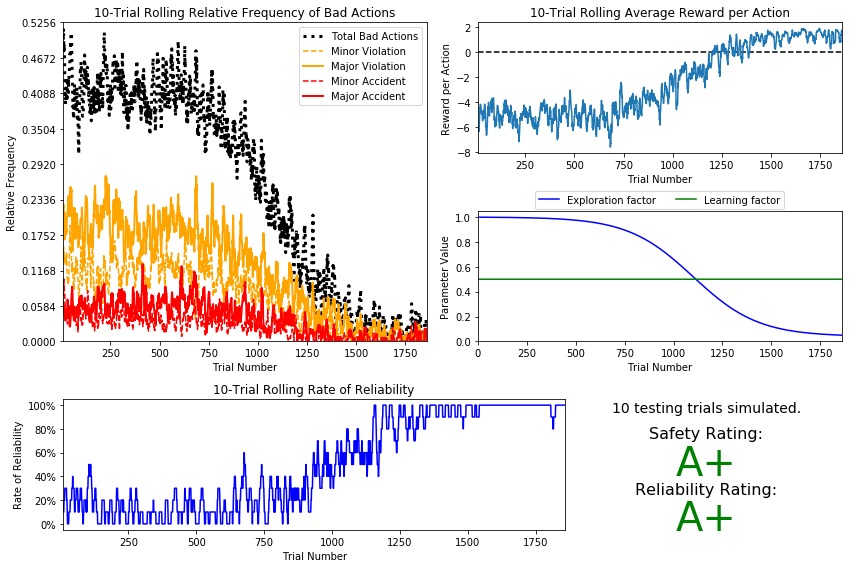

In [4]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**
 - I have used a logistic decay function: $ \epsilon = \frac{0.96}{(1 + e^{(a * t))})} + 0.04; a = 0.006, t \ge 0 $. Then at t = 0 the initial epsilon = 1.
 - About 1800 training trials were conducted, 5 times the number of states. This allowed the agent to visit each state about several times.
 - I have used epsilon-tolerance 0.05 for the training trials with a logistic function. I let epsilon go from 1 towards 0.05 as the training progressed. This allowed initial learning rate to remain high to maximize the chances of visiting each state. Then the learning rate decays and approaches the tolerance level of 0.05 when the agent mostly uses learned q values. Training stops when there is a 1:20 ratio of exploration:exploitation and the agent is assumed to have learned a good policy by then. The learning rate was kept 0.5 throughout the experiment to allow for a uniform convergence of the final Q value. 
 - This Q-learner has made significant improvements over the default learner. The major difference I believe is the number of training steps made.
 - I can conclude that the Q-learner has successfully learned a policy that gives it A+ ratings according to the scorer. 
 - I am satisfied with the fact that Reliability stay consistently over 60%, Reward functinon is consistently positive. That means the the Smatcab is not making any mistakes. The Bad Actions curves have levelled out but it seems that its above zero. I believe that they can be smoothed out with a epsilon decay that goes to zero and longer training.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

 1. The optimal policy should be that which gives the highest reward for the correct action taken in each state. The policy should be an implementaion of the traffic laws that govern driver behavior and gets the agent to the destination following the calculated waypoint. In general the agent should be going in the direction of `waypoint` unless it violates traffic law. The policy could be summarized as a table that gives an action for each of the permutations of all the possible states the agent can be in. For example list all states when the light is `Red`. Then all the only legal action is `right`, but if traffic from the left is `None` else `None`. When the light is `Green`, the valid actions are `right|forward|left` if oncoming traffic is `left|None`. If the waypoint = `left` and oncoming traffic is `forward|right`, the best action is `None`. 
 - Investigating the `'sim_improved-learning.txt'` text file, we can see that the policy is not been learned perfectly. There are 46 policy violations out of 384 states or about 12 percent of the cases. But there are no collisions and this result is good enought to get the smartcab to its destination. In real life cabs don't always take the best route but still get to their destination on time.
       Optimal policy example 1: 
       Smartcab waypoint is 'left', and the action with the highest q-value is also `left`. The light is green and there is no oncoming traffic. Cross traffic lights are red, so the agent can proceed. 
       way_point: left
       q_action   : left
       ('left', (('left', 'left'), ('light', 'green'), ('oncoming', None), ('right', 'forward')))
       {'forward': '0.90', 'None': '-5.25', 'right': '0.81', 'left': '1.41'}
        
       Optimal policy example 2: Smartcab waypoint is 'left', and the action with the highest q-value is also `left`. The light is green and oncoming traffic is going `left`. Cross traffic lights are red, so the agent can proceed. 
       way_point: left
       q_action   : left
       ('left', (('left', 'left'), ('light', 'green'), ('oncoming', 'left'), ('right', 'forward')))
       {'forward': '0.75', 'None': '-4.52', 'right': '0.74', 'left': '2.22'}
      
       Optimal policy example 3: Smartcab waypoint is 'forward', and the action with the highest q-value is also 'forward'. The light is green and oncoming traffic is going `forward`. Cross traffic lights are red, so the agent can proceed. 
       way_point: forward
       q_action   : forward
       ('forward', (('left', 'right'), ('light', 'green'), ('oncoming', 'forward'), ('right', None)))
       {'forward': '1.35', 'None': '-4.84', 'right': '0.40', 'left': '-18.87'}
   
   
 - The following is not an optimal policy. The light is `red` and agent is heading `right`. Although the `right` action has the lowest q-value, `forward|None|left` have all 0.00 as q-value, and since the agent will pick one randomly it has the risk of running a red light. See code below.
  - state: ('right', (('left', 'forward'), ('light', 'red'), ('oncoming', 'right'), ('right', 'right')))
  - q    : {'forward': '0.00', 'None': '0.00', 'right': '-9.93', 'left': '0.00'}



## Diagnostic code relating to question 8

In [5]:
# Theoretical policy table to be filled out
import numpy as np
import pandas as pd
pd.options.display.max_rows = 15

dumy_dirs = [1, 2, 3, 4] # Directions Dummies can take
lights = [5, 6] # Light colors: Green and Red
heading = [7, 8, 9] # heading the Smartcab is going
# Map state labels to human-readable values
d_map = {1:'None', 2:'Left', 3:'Forward',4:'Right', 5:'Green',6:'Red',7:'left',8:'forward',9:'right'}

# Generate a matrix of state variable permuations
mg = np.meshgrid(dumy_dirs,dumy_dirs,dumy_dirs, lights, heading)
mg = np.array(mg).T.reshape(-1,) 
policy = pd.DataFrame(np.array(map(d_map.get, mg)).reshape(-1,5), 
             columns=['L Dummy', 'O Dummy', 'R Dummy', 'Lights','Heading'])
policy['Action'] = '?'

policy



,L Dummy,O Dummy,R Dummy,Lights,Heading,Action
0,None,None,None,Green,left,?
1,None,Left,None,Green,left,?
2,None,Forward,None,Green,left,?
3,None,Right,None,Green,left,?
4,Left,None,None,Green,left,?
5,Left,Left,None,Green,left,?
6,Left,Forward,None,Green,left,?
...,...,...,...,...,...,...
377,Forward,Left,Right,Red,right,?
378,Forward,Forward,Right,Red,right,?


In [6]:
#{(state):{a1:q1, a2:q2}, ...}
# this script detects policy violations
from ast import literal_eval as make_tuple

def read_learning():
    '''
    Read in the policy file
    '''
    lines = [line.rstrip('\n') for line in open("logs/sim_improved-learning.txt")]
    q = {} # Q table
    qn = {} # Q values for current state

    state = tuple()
    for ln, line in enumerate(lines[4:]):
        if ln % 6 == 5:
            continue
        elif ln % 6 == 0: # new state
            state = make_tuple(line)
            qn = {}
            q[state] = qn
            #print make_tuple(line)
        else:
            action = line.split(' : ')[0][4:]
            reward = line.split(' : ')[1]
            qn[action] = reward
            #print action, reward
    return q

def q_action(q,state):
    """Action recommended by q"""
    return [k for k,v in q[state].iteritems() if v == max(q[state].values())][0]

q = read_learning()

# print out policy for 'red'.
for state in q.keys():
    if 'red' == state[1][1][1]:
        left_dummy = state[1][0][1] # heading

        # if left = forward or oncoming = left -> None
        if (left_dummy in ['forward']) and (q_action(q,state) in ['right']):            
            print '\n== Red light policy violation, right turn with cross traffic =='
            print 'left_dummy:', left_dummy 
            print 'q_action:', q_action(q,state)
            print 'state:', state
            print 'q    :', q[state]
        elif (q_action(q,state) in ['forward', 'left']):
            print '\n== Red light policy violation, running red light =='
            print 'q_action:', q_action(q,state)
            print 'state:', state
            print 'q    :', q[state]
            
pol = 0
col = 0
opt = 0
# print out direction policy violations
for state in q.keys():
    if 'green' == state[1][1][1]:
        # If the waypoint = left and oncoming traffic is forward|right, the best action is None.
        oncoming_dummy = state[1][2][1] # heading
        way_point = state[0]
        
        # When the light is Green, the valid actions are right|forward|left if oncoming traffic is left|None. 
        if (oncoming_dummy in ['forward', 'right']) and (q_action(q,state) in ['left']):            
            print '\n== Collision with oncoming traffic during left turn =='
            print 'oncoming_dummy:', oncoming_dummy 
            print 'q_action:', q_action(q,state)
            print 'state:', state
            print 'q    :', q[state]
            col += 1
            continue
            
        if way_point == q_action(q,state):
            #print '\n== Optimal Policy: =='
            #print 'way_point:', way_point
            #print 'q_action   :', q_action(q,state)
            #print state
            #print q[state]
            opt += 1
                
        if way_point != q_action(q,state):
            #print '\n== Direction policy violation: =='
            #print 'way_point:', way_point
            #print 'q_action   :', q_action(q,state)
            #print state
            #print q[state]
            pol += 1
print "\nNumber of policy violations:", pol
print "Number of collisions:", col
print "Number of optimal policy when green:", opt



== Red light policy violation, running red light ==
q_action: forward
state: ('right', (('left', 'forward'), ('light', 'red'), ('oncoming', 'right'), ('right', 'right')))
q    : {'forward': '0.00', 'None': '0.00', 'right': '-9.93', 'left': '0.00'}

== Red light policy violation, running red light ==
q_action: forward
state: ('forward', (('left', 'right'), ('light', 'red'), ('oncoming', 'left'), ('right', 'right')))
q    : {'forward': '0.00', 'None': '0.00', 'right': '0.00', 'left': '-7.68'}

Number of policy violations: 46
Number of collisions: 0
Number of optimal policy when green: 145


-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**
 - The agent is not able to see beyond the current state/intersection which makes it impossible to calculate future rewards. It cannot select an optimal action beyond its current state because by the time it gets there the state will have changed. The dummy agents will have rearranged themselves in an unpredictable way and the light may be a different color. By the time the agent gets to the next intersection the grid will be in a different state which unvalidates the reward calculation. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.